# Instructions

The code below fits a simple neural network to a dataset. The goal of this exercise is to fill-in some missing functions in the implementation.

Please read the instructions and the code carefully before beginning to implement.
## The Model
Our neural network conatins a single hidden layer which is followed by an output layer. The network is defined as follows.

Given the input vector $x \in \mathbb{R}^{D_x}$, the hidden layer outputs the vector $h \in \mathbb{R}^{D_h}$ which is given as
\begin{align}h = f(Ax+b) \end{align}where:
* $A \in \mathbb{R}^{D_x \times D_h}$ is a weights matrix
* $b \in \mathbb{R}^{D_h}$ is a bias vector
* $f$ is the Swish activation function, given by $f(x)=x*sigmoid(x)$

The output layer takes $h$ as in input and produces the output vector $y$, which is given as
   

\begin{align}y = Ch+d\end{align}where:
* $C \in \mathbb{R}^{D_h \times D_y}$ is a weights matrix
* $d \in \mathbb{R}^{D_y}$ is a bias vector

## The Task

### Implementing the Model
The $NeuralNetSolver$ class contains the definition of the model, the forward and backward pass calculation and the fitting method. Please make the following changes in that class:
1. (5 pts) Implement the $get\_loss$ method to calculate a Mean Squared Error loss.
2. (5 pts) Implement the $forward$ method according to the definition of the model.
3. (40 pts) Implement the method $get\_layer\_1\_grads$ which should return the gradients of the hidden layer's weights matrix $A$ and biases vector $b$. For a refresher on how to do the math, see e.g. [here](https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf) (note that this example uses a different activation function).

### Improving the Termination Criteria of the Solver
(10 pts) The $TerminationCriteria$ class contains the criteria that determine when to stop training the model. The stub implementation simply stops after a predetermined number of iterations. Please change the implementation so that it would be more effective and robust.

### Improving the Optimizer
The $Optimizer$ class takes care of calculating the parameter updates, given the gradients. The stub implementation is a simple gradient descent and it is slow to converge. Please change it to have:
1. (20 pts) A [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) term.
2. (20 pts) An adaptive learning rate for each parameter, as defined in [RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp).

# Imports

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from typing import Tuple, List, Collection, Mapping


# Optimizer

In [64]:
class Optimizer:
    """
      This class is responsible for calculating parameter updates during optimization.
    """
    LEARNING_RATE = 1e-2
    BETA1 = 0.9
    BETA2 = 0.999
    EPSILON = 1e-8

    def __init__(self, param_names: Collection[str]):
        """
        :param param_names:
          A list of the parameter names to be optimized.
        """
        self.param_names = param_names
        self.m = {}
        self.v = {}
        for param_name in param_names:
            self.m[param_name] = np.zeros_like(self.param_names[param_name])
            self.v[param_name] = np.zeros_like(self.param_names[param_name])

    def step(self, param_grads: Mapping[str, np.array]) -> Mapping[str, np.array]:
        """
            Calculate the parameter updates for a single step of optimization.
        :param param_grads:
            A dictionary of the parameter gradients.
        :return:
          A dictionary of parameter updates.
        """
        param_updates = {}
        for param_name, param_grad in param_grads.items():
            self.m[param_name] = self.BETA1 * self.m[param_name] + (1 - self.BETA1) * param_grad
            self.v[param_name] = self.BETA2 * self.v[param_name] + (1 - self.BETA2) * param_grad ** 2
            m_hat = self.m[param_name] / (1 - self.BETA1)
            v_hat = self.v[param_name] / (1 - self.BETA2)
            param_updates[param_name] = self.LEARNING_RATE * m_hat / (np.sqrt(v_hat) + self.EPSILON)

        return param_updates



# Termination Criteria

In [91]:
class TerminationCriteria:
    def __init__(self, max_iter, min_train_loss):
        self.max_iter = max_iter
        self.min_train_loss = min_train_loss
        self.best_loss = np.inf
        self.patience = 10

    def is_over(self, iter: int, training_loss: float) -> bool:
        """
        : iter
            The iteration number
        :return:
            True if the optimization should terminate, False otherwise.
        """
        if training_loss < self.best_loss:
            self.best_loss = training_loss
            self.patience = 10
        else:
            self.patience -= 1
        return iter > self.max_iter or training_loss < self.min_train_loss or self.patience == 0


# Model

In [95]:
class NeuralNetSolver:
    HIDDEN_DIM = 32
    INPUT_DIM = 1
    OUTPUT_DIM = 1

    MAX_ITER = 100000
    MIN_TRAIN_LOSS = 1e-2
    INIT_RANGE = 1
    NUM_EVALS = 100

    def __init__(self):
        """
        C'tor
        :param input_dim:
            The dimension of the input vector
        """
        self.params_dict = {
            'weights_1': np.random.normal(0, self.INIT_RANGE, (self.INPUT_DIM, self.HIDDEN_DIM)),
            'bias_1': np.zeros(shape=(1, self.HIDDEN_DIM)),
            'weights_2': np.random.normal(0, self.INIT_RANGE, (self.HIDDEN_DIM, self.OUTPUT_DIM)),
            'bias_2': np.zeros(shape=(1, self.OUTPUT_DIM))}
        # print("==================init shapes=====================")
        # print("W1: " ,self.params_dict['weights_1'].shape)
        # print("b1: " ,self.params_dict['bias_1'].shape)

        # print("W2: " ,self.params_dict['weights_2'].shape)
        # print("b2: " ,self.params_dict['bias_2'].shape)

        # print("========================================")
        self.optimizer = Optimizer(self.params_dict)
        self.termination_criteria = TerminationCriteria(self.MAX_ITER, self.MIN_TRAIN_LOSS)

    @staticmethod
    def act_fn(x: np.array) -> np.array:
        """
            The activation function.
        :param x:
            An input array
        :return:
            The result of activation function applied to the x element-wise.
        """
        return x / (1 + np.exp(-x))
    @staticmethod
    def sigmoid(x):
       return 1 / (1 + np.exp(-x))
    @staticmethod
    def swish_prime(x):
      return NeuralNetSolver.act_fn(x) + NeuralNetSolver.sigmoid(x)*(1 -  NeuralNetSolver.act_fn(x))


    def forward(self, x: np.array) -> np.array:
        """
        Makes a prediction with the model.
        :param x:
            A batch of input feature vectors. The shape is [B, D_IN], where B is the batch dimension
            and D_IN is the dimension of the feature vector.
        :return:
            A batch of predictions. The shape is [B, D_OUT], where B is the batch dimension
            and D_OUT is the dimension of the prediction vector.
        """
        assert x.shape[1] == self.params_dict['weights_1'].shape[0]


        # PLEASE IMPLEMENT THE FORWARD PASS HERE
        # result = np.zeros((x.shape[0], self.OUTPUT_DIM))
        hidden1 = NeuralNetSolver.act_fn(x @ self.params_dict['weights_1'] + self.params_dict['bias_1'])
        # print("Hidden layer after activation: ", hidden1.shape)
        result = hidden1 @ self.params_dict['weights_2'] + self.params_dict['bias_2']

        assert result.ndim == 2
        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.OUTPUT_DIM

        return result

    def get_loss_grad(self, X: np.array, y: np.array) -> Mapping[str, np.array]:
        """
            Calculates the gradient of the loss function.
        :param X:
            A batch of input feature vectors. The shape is [B, D_IN], where B is the batch dimension
            and D_IN is the dimension of the feature vector.
        :param y:
            A batch of outputs. The shape is [B, D_OUT], where B is the batch dimension
            and D_OUT is the dimension of the output vector.
        :return:
            A
        """
        layer_1_out = X @ self.params_dict['weights_1'] + self.params_dict['bias_1']
        # print("layer 1 out dimension without activation", layer_1_out.shape)
        layer_2_out = self.forward(X)
        # print("layer 2 out dimension", layer_2_out.shape)

        weights2_grad, bias2_grad = self.get_layer_2_grads(X, y, layer_1_out, layer_2_out)

        # print("weight2_gradient: ", weights2_grad.shape)
        # print("biast2_gradient: ", bias2_grad.shape)

        weights1_grad, bias1_grad = self.get_layer_1_grads(X, y, layer_1_out, layer_2_out)


        return {'weights_1': weights1_grad, 'bias_1': bias1_grad,
                'weights_2': weights2_grad, 'bias_2': bias2_grad}

    def get_layer_1_grads(self, X: np.array, y: np.array,
                          layer_1_out: np.array, layer_2_out: np.array) -> Tuple[
        np.array, np.array]:
        """
            Calculates the gradients for the first layer of the neural network.
        :param X:
            A batch of input feature vectors. The shape is [B, D_IN], where B is the batch dimension
            and D_IN is the dimension of the feature vector.
        :param y:
            A batch of outputs. The shape is [B, D_OUT], where B is the batch dimension
            and D_OUT is the dimension of the output vector.
        :param layer_1_out:
            The output of the first linear layer, without activation.
        :param layer_2_out:
            The output of the 2nd layer.
        :return:
            A [HIDDEN_DIM] numpy array of weight gradients and a [1] numpy array of bias gradients
        """

        # PLEASE REPLACE THE FOLLOWING TWO LINES WITH A CALCULATION OF THE GRADIENTS

        delta_o = (layer_2_out - y)
        # print("Delta_o_shape: ", delta_o.shape)

        delta_h = (delta_o @ (self.params_dict['weights_2'].T)) * self.swish_prime(layer_1_out)

        # print("shape of delta_h", delta_h.shape)

        weights1_grad = (delta_h.T @ X).T
        # np.zeros((self.INPUT_DIM, self.HIDDEN_DIM))
        bias1_grad = delta_h.sum(axis=0,keepdims=True)
        # np.zeros((1, self.HIDDEN_DIM))

        # print("====W1,b1 gradients=======")
        # print(weights1_grad.shape)
        # print(bias1_grad.shape)


        assert weights1_grad.shape[0] == self.INPUT_DIM
        assert weights1_grad.shape[1] == self.HIDDEN_DIM
        assert weights1_grad.ndim == 2

        assert bias1_grad.shape[0] == 1
        assert bias1_grad.shape[1] == self.HIDDEN_DIM
        assert bias1_grad.ndim == 2

        return weights1_grad, bias1_grad

    def get_layer_2_grads(self, X: np.array, y: np.array,
                          layer_1_out: np.array, layer_2_out: np.array) -> Tuple[
        np.array, np.array]:
        """
               Calculates the gradients for the second layer of the neural network.
           :param X:
               A batch of input feature vectors. The shape is [B, D_IN], where B is the batch dimension
               and D_IN is the dimension of the feature vector.
           :param y:
               A batch of outputs. The shape is [B, D_OUT], where B is the batch dimension
               and D_OUT is the dimension of the output vector.
           :param layer_1_out:
               The output of the first linear layer, without activation.
           :param layer_2_out:
               The output of the 2nd layer.
           :return:
               A [HIDDEN_DIM] numpy array of weight gradients and a [1] numpy array of bias gradients
           """
        weights2_grad = ((layer_2_out - y).T @ self.act_fn(layer_1_out)).T
        bias2_grad = np.sum((layer_2_out - y), keepdims=True)

        assert weights2_grad.ndim == 2
        assert weights2_grad.shape[0] == self.HIDDEN_DIM
        assert weights2_grad.shape[1] == self.OUTPUT_DIM

        assert bias2_grad.shape[0] == 1
        assert bias2_grad.ndim == 2

        return weights2_grad, bias2_grad

    @staticmethod
    def get_loss(y, y_hat) -> np.array:
        """
            Calculate the loss
        :param y:
            The ground-truth responses.
        :param y_hat:
            The predicted responses.
        :return:
            A scalar containing the loss.
        """
        # PLEASE REPLACE WITH AN IMPLEMENTATION OF THE LOSS
        # print(y)
        # print(y_hat)
        return np.mean((y-y_hat) ** 2)

    def fit(self, X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array) -> \
    Tuple[List, List]:
        """
            Fits the model to the given data.
        :param X_train:
            The training features
        :param y_train:
            The training outputs
        :param X_test:
            The test features
        :param y_test:
            The test output
        :return:
            The train losses and the test losses
        """
        iter = 0
        train_losses = []
        test_losses = []

        steps_for_eval = self.MAX_ITER // self.NUM_EVALS
        print(f"steps_for_eval={steps_for_eval}")

        train_loss = np.inf # sentinel
        while not self.termination_criteria.is_over(iter,train_loss):
            y_hat = self.forward(X_train)
            train_loss = self.get_loss(y_hat, y_train)
            print(f'Iteration {iter}, Train Loss={train_loss}')
            loss_grad = self.get_loss_grad(X_train, y_train)

            param_update_dict = self.optimizer.step(loss_grad)

            for param_name, param_update in param_update_dict.items():
                self.params_dict[param_name] -= param_update

            iter += 1
            if iter % steps_for_eval == 0:
                y_hat = self.forward(X_test)
                test_loss = self.get_loss(y_hat, y_test)
                train_losses.append(train_loss)
                test_losses.append(test_loss)

                print(f'Iteration {iter}, Test Loss={test_loss}')
        return train_losses, test_losses

# Generate Data and Train

In [96]:
X = np.expand_dims(np.linspace(0, 100, 50), -1)

y = np.expand_dims((5 * X[:, 0] + 3 * X[:, 0] ** 2 + 50), -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

nn = NeuralNetSolver()
train_losses, test_losses = nn.fit(X_train, y_train, X_test, y_test)

Streaming output truncated to the last 5000 lines.
Iteration 11570, Train Loss=331080.75712803536
Iteration 11571, Train Loss=330884.7180908242
Iteration 11572, Train Loss=330688.7514229075
Iteration 11573, Train Loss=330492.85769781703
Iteration 11574, Train Loss=330297.0374732452
Iteration 11575, Train Loss=330101.29129013384
Iteration 11576, Train Loss=329905.619673241
Iteration 11577, Train Loss=329710.0231298336
Iteration 11578, Train Loss=329514.5021506621
Iteration 11579, Train Loss=329319.0572084046
Iteration 11580, Train Loss=329123.68875888956
Iteration 11581, Train Loss=328928.3972394058
Iteration 11582, Train Loss=328733.18307007616
Iteration 11583, Train Loss=328538.0466521077
Iteration 11584, Train Loss=328342.98836924334
Iteration 11585, Train Loss=328148.00858598656
Iteration 11586, Train Loss=327953.1076491252
Iteration 11587, Train Loss=327758.2858859108
Iteration 11588, Train Loss=327563.54360567435
Iteration 11589, Train Loss=327368.88109792816
Iteration 11590, Trai

# Loss Plot

Text(0.5, 0, 'Step')

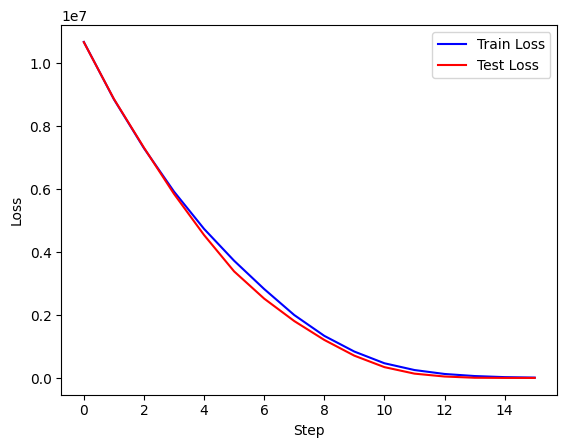

In [97]:
plt.plot(range(len(train_losses)), train_losses, 'b')
plt.plot(range(len(train_losses)), test_losses, 'r')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Step')

# Plot of True vs Predicted Values

Text(0, 0.5, 'Predicted')

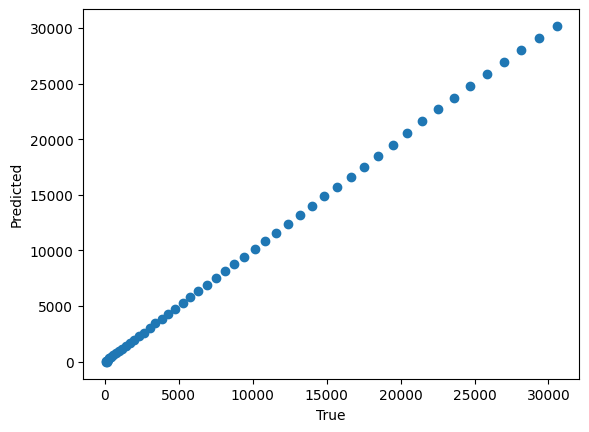

In [98]:
plt.scatter(y, nn.forward(X))
plt.xlabel('True')
plt.ylabel('Predicted')